<a href="https://colab.research.google.com/github/infinity-void6/Anomaly-Detection-using-MIL-with-C2D/blob/main/tutorial_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## Connect to your google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install h5py numpy tqdm pillow matplotlib ipython torch torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manyl

In [ ]:
import importlib
import math
import json
import os
import h5py
import numpy as np
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
from IPython.display import display
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
import torch.nn.functional as F

In [ ]:
def display_thumbnail(img_fpath: str, downsample: float=4.0):
    img = Image.open(img_fpath)
    w, h = img.size
    img = img.resize((int(w/downsample), int(h/downsample)))
    display(img)

# Overview

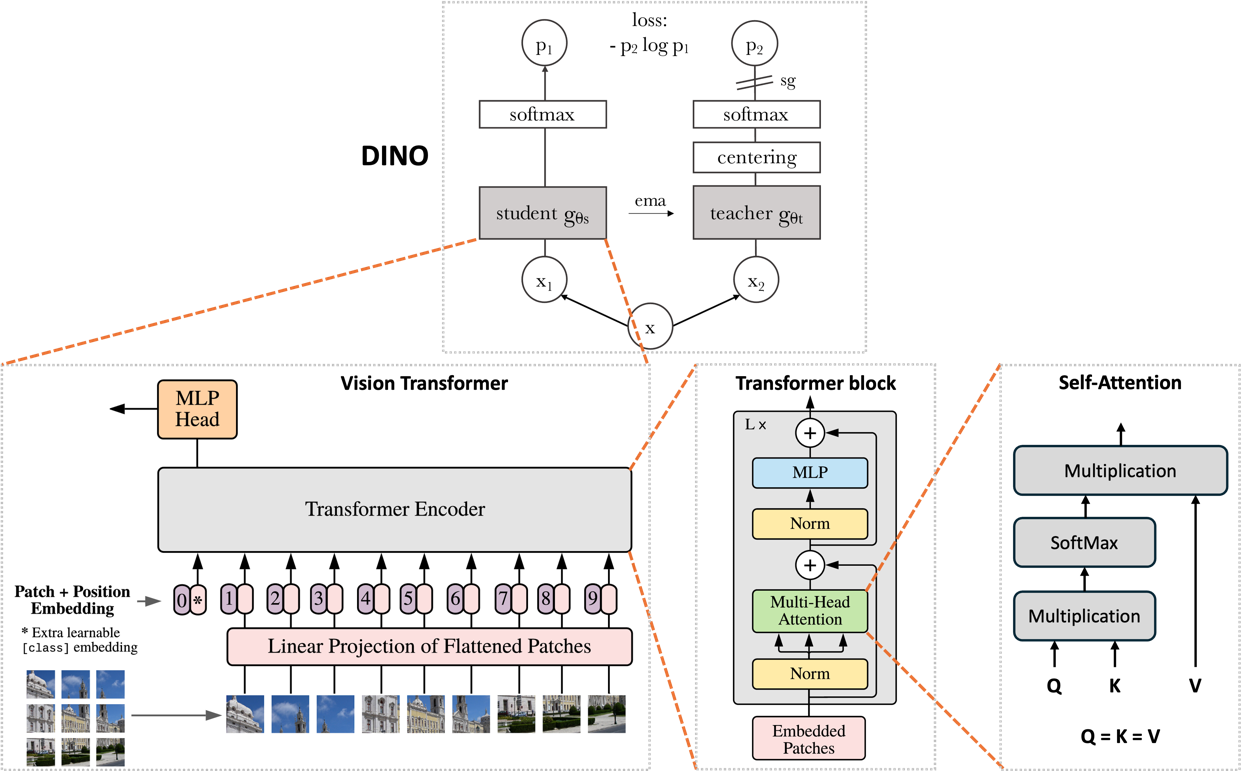

In [ ]:
# Constants
base_dir = '/content/drive/My Drive/mlss24/'
display_thumbnail(img_fpath=base_dir+'thumbnails/overview.png', downsample=3)

# Constants

In [ ]:
import sys
import os

# Assuming your project folder is in the root of your Google Drive
project_path = '/content/drive/My Drive/mlss24/code'

# Add the path to sys.path
if project_path not in sys.path:
    sys.path.append(project_path)

# Optional: Print sys.path to verify
print(sys.path)


['/content', '/env/python', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.10/dist-packages/IPython/extensions', '/root/.ipython', '/content/drive/My Drive/mlss24/code']


In [ ]:
# Constants
base_dir = '/content/drive/My Drive/mlss24/'
train_data_fpath = os.path.join(base_dir, 'data/train_split_data.h5')
val_data_fpath = os.path.join(base_dir, 'data/val_split_data.h5')
test_data_fpath = os.path.join(base_dir, 'data/test_split_data.h5')

train_labels_fpath = os.path.join(base_dir, 'data/train_split_labels.h5')
val_labels_fpath = os.path.join(base_dir, 'data/val_split_labels.h5')
test_labels_fpath = os.path.join(base_dir, 'data/test_split_labels.h5')

# dino_checkpoint_dir = os.path.join(base_dir, 'data', 'dino_checkpoint')
dino_checkpoint_dir = os.path.join('dino_checkpoint')
os.makedirs(dino_checkpoint_dir, exist_ok=True)
pretrained_checkpoint_dir = os.path.join(base_dir, 'data', 'pretrained_checkpoint')

# Histopathology: PatchCamelyon Data

In [ ]:
# read dataset
def read_dataset(file_path: str):
    with h5py.File(file_path, 'r') as h5file:
        data = h5file[list(h5file.keys())[0]]
        return data[:]

# visualize images
def visualize_images(data: np.ndarray, seed: int):
    # randomly sample 10 images
    np.random.seed(seed)
    idx = np.random.choice(data.shape[0], size=10, replace=False)
    patches = data[idx]

    # create a figure
    nrows, ncols = 2, 5
    fig, axes = plt.subplots(nrows, ncols, figsize=(10, 4))
    axes = axes.flatten()
    # plot each image
    for i in range(nrows * ncols):
        axes[i].imshow(patches[i])
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
# read train data
data = read_dataset(file_path=train_data_fpath)
print('training data: ', data.shape)

training data:  (500, 96, 96, 3)


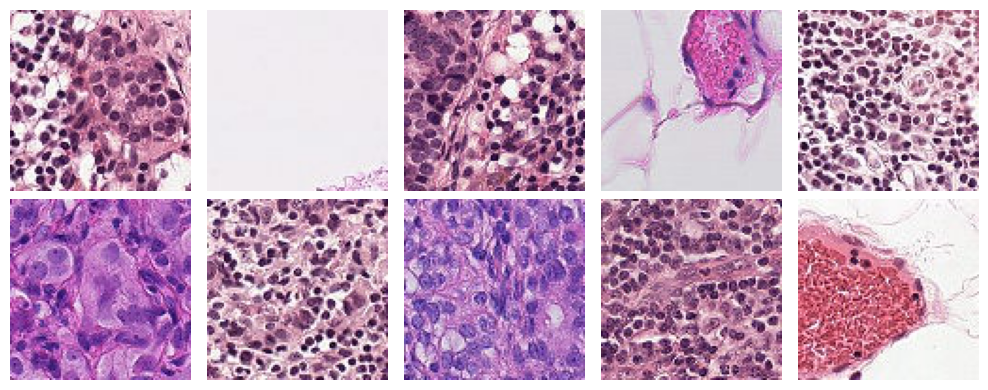

In [ ]:
# visualize random images from the data
visualize_images(data=data, seed=10)

# Basics

In [ ]:
class MLP(nn.Module):
    def __init__(
        self, input_dim, hidden_dim, output_dim, is_verbose=False
    ):
        '''
        :param input_dim: input dimension
        :param hidden_dim: hidden dimension
        :param output_dim: output dimension
        :param is_verbose: flag indicating whether to print
        '''
        super().__init__()
        self.is_verbose = is_verbose

        self.fc_layer1 = nn.Linear(input_dim, hidden_dim)
        self.activation = nn.GELU()
        self.fc_layer2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, input: torch.Tensor):
        '''
        :param input: input tensor of shape (batch_size, input_dim)
        :return: return tensor of shape (batch_size, output_dim)
        '''
        x = self.fc_layer1(input)
        if self.is_verbose:
            print('FC1 output: ', x.shape)

        x = self.activation(x)
        if self.is_verbose:
            print('Activation output: ', x.shape)

        x = self.fc_layer2(x)
        if self.is_verbose:
            print('FC2 output: ', x.shape)

        return x

In [ ]:
# Example:

# define input: (batch_size, input_dim)
batch_size, input_dim, hidden_dim, output_dim = 1, 128, 32, 64
input = torch.randn(batch_size, input_dim)
print('Input: ', input.shape, '\n')

# instantiate attention
model = MLP(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, is_verbose=True)

# forward pass
output = model(input)

# sanity check
assert output.shape == (batch_size, output_dim)
print('Successful: Output shape is correct!')

Input:  torch.Size([1, 128]) 

FC1 output:  torch.Size([1, 32])
Activation output:  torch.Size([1, 32])
FC2 output:  torch.Size([1, 64])
Successful: Output shape is correct!


# Self Attention

### Single-head Self attention

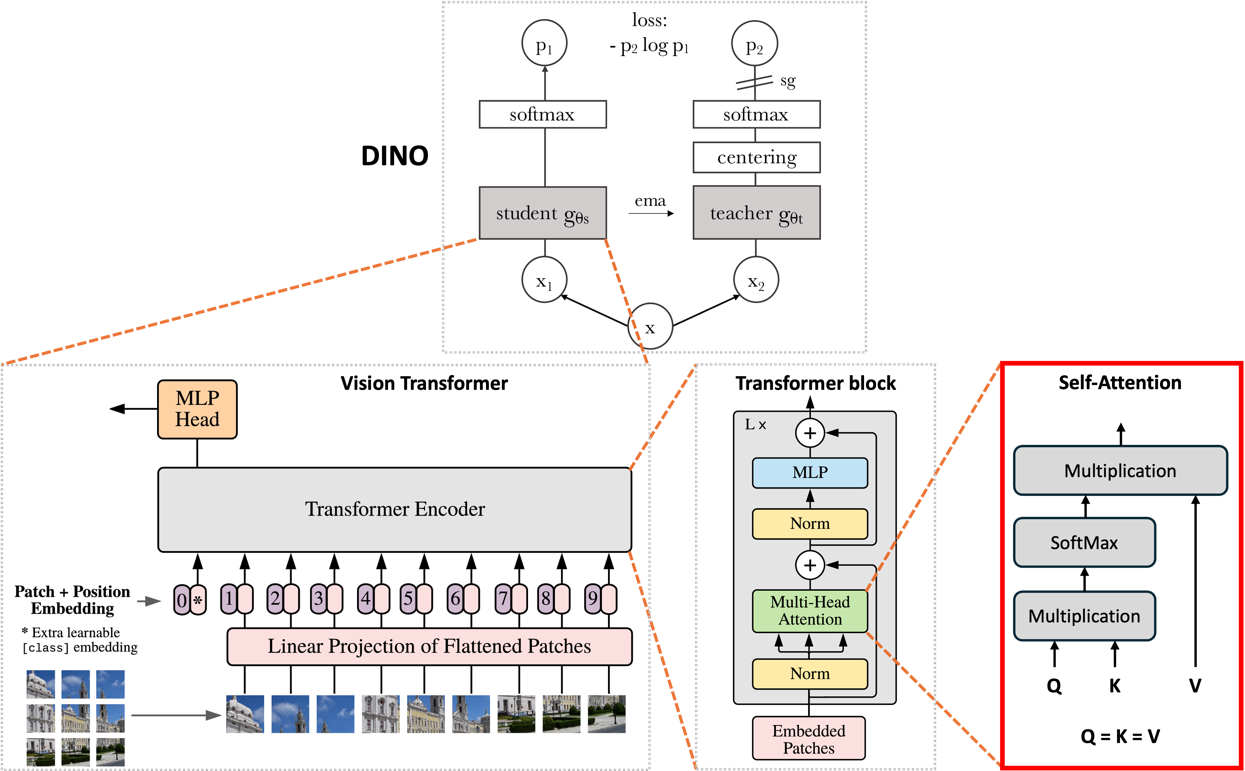

In [ ]:
display_thumbnail(img_fpath=base_dir+'thumbnails/overview_selfattention.png', downsample=3)

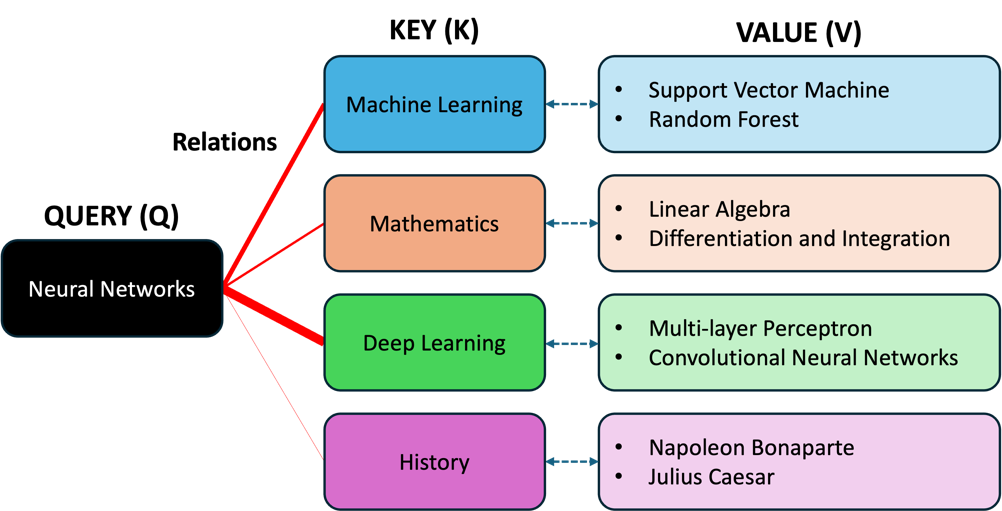

In [ ]:
display_thumbnail(img_fpath=base_dir+'thumbnails/attention_example.png', downsample=3)

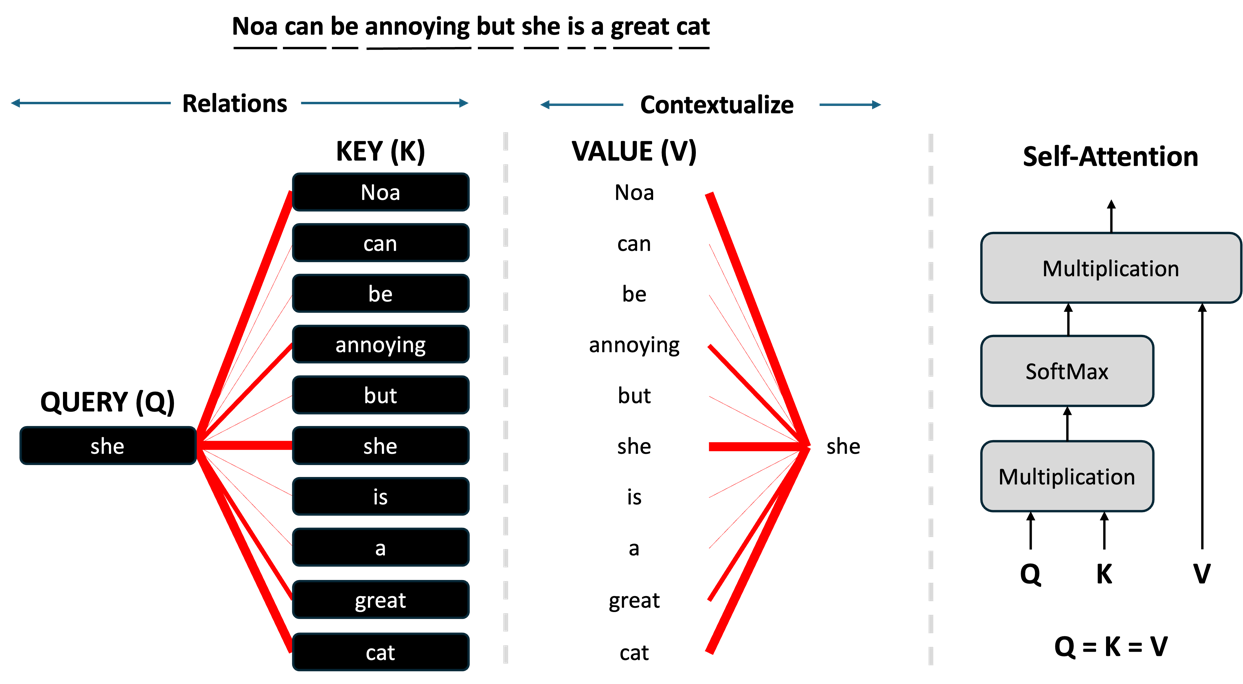

In [ ]:
display_thumbnail(img_fpath=base_dir+'thumbnails/self_attention_example.png', downsample=3)

In [ ]:
class SingleHeadSelfAttention(nn.Module):
    def __init__(
        self, input_dim, hidden_dim
    ):
        '''
        :param input_dim: input dimension of each token
        :param hidden_dim: hidden dimension of each token
        '''
        super(SingleHeadSelfAttention, self).__init__()

        self.hidden_dim = hidden_dim

        # projection layers to define Q,  K, V
        self.query = nn.Linear(input_dim, hidden_dim)    # W_q
        self.key = nn.Linear(input_dim, hidden_dim)      # W_k
        self.value = nn.Linear(input_dim, hidden_dim)    # W_v

        # output projection layer
        self.output_projection = nn.Linear(hidden_dim, input_dim)

    def forward(
        self, input: torch.Tensor
    ):
        '''
        :param input: input of shape (batch_size, num_tokens, input_dim)
        :return: self-attented output of shape (batch_size, num_tokens, hidden_dim)
        '''

        self.batch_size, self.num_tokens, self.input_dim = input.shape

        # compute Q, K, V
        Q = self.query(input)       # (batch_size, num_tokens, hidden_dim)
        K = self.key(input)         # (batch_size, num_tokens, hidden_dim)
        V = self.value(input)       # (batch_size, num_tokens, hidden_dim)
        print('Query: ', Q.shape, 'Key: ', K.shape, 'Value: ', V.shape, '\n')

        # compute query-to-key attentions                                                    # (batch_size, num_tokens, num_tokens)
        query_to_key_attention = self._query_key_multiply(query=Q, key=K)
        print('Query-to-Key attention: ', query_to_key_attention.shape, '\n')

        # scaling for stability
        query_to_key_attention = self._scaling(query_to_key_attention)                      # (batch_size, num_tokens, num_tokens)
        query_to_key_attention = self._softmax(query_to_key_attention)                      # (batch_size, num_tokens, num_tokens)
        print('Query-to-Key attention after scaling: ', query_to_key_attention.shape, '\n')

        # contextualize                                                                     # (batch_size, num_tokens, hidden_dim)
        attention_output = self._contextualize_with_value(
            attention=query_to_key_attention,
            value=V
        )
        print('Contextualized Values: ', attention_output.shape, '\n')

        # project the tokens back to input dim                                              # (batch_size, num_tokens, input_dim)
        output = self.output_projection(attention_output)
        print('Output: ', output.shape)

        return output

    def _query_key_multiply(self, query, key):
        return torch.matmul(query, key.transpose(-2, -1))

    def _scaling(self, x):
        return x / (self.hidden_dim ** 0.5)

    def _softmax(self, x):
        return F.softmax(x, dim=-1)

    def _contextualize_with_value(self, attention, value):
        return torch.matmul(attention, value)


In [ ]:
# Example:

# define input: (batch_size, num_tokens, dim)
batch_size, num_tokens, input_dim = 1, 10, 128
input = torch.randn(batch_size, num_tokens, input_dim)
print('Input: ', input.shape, '\n')

# instantiate attention
model = SingleHeadSelfAttention(input_dim=input_dim, hidden_dim=64)

# forward pass
output = model(input)

# sanity check
assert output.shape == input.shape
print('Successful: Output and Input shapes are matched!')

Input:  torch.Size([1, 10, 128]) 

Query:  torch.Size([1, 10, 64]) Key:  torch.Size([1, 10, 64]) Value:  torch.Size([1, 10, 64]) 

Query-to-Key attention:  torch.Size([1, 10, 10]) 

Query-to-Key attention after scaling:  torch.Size([1, 10, 10]) 

Contextualized Values:  torch.Size([1, 10, 64]) 

Output:  torch.Size([1, 10, 128])
Successful: Output and Input shapes are matched!


### Multi-head Self Attention

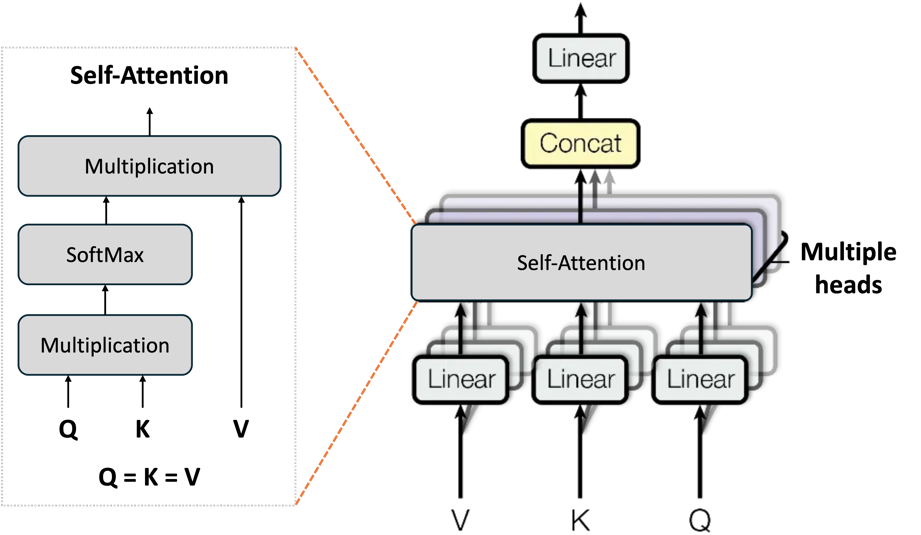

In [ ]:
display_thumbnail(img_fpath=base_dir+'thumbnails/multi_head_self_attention.png')

In [ ]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(
        self, input_dim, hidden_dim, num_heads, is_verbose=False
    ):
        '''
        :param input_dim: input dimension of each token
        :param hidden_dim: hidden dimension of each token
        :param num_heads: number of attention heads
        :param is_verbose: flag indicating whether to print outputs
        '''

        super(MultiHeadSelfAttention, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads
        self.is_verbose = is_verbose

        # split the hidden_dim budget across all attention-heads
        self.head_dim = hidden_dim // num_heads
        assert self.head_dim * num_heads == hidden_dim, "dim must be divisible by num_heads"

        # projection layers to define Q,  K, V
        self.query = nn.Linear(input_dim, hidden_dim)
        self.key = nn.Linear(input_dim, hidden_dim)
        self.value = nn.Linear(input_dim, hidden_dim)

        # output projection layer
        self.output_projection = nn.Linear(hidden_dim, input_dim)

    def forward(
        self, input: torch.Tensor
    ):
        '''
        :param input: input of shape (batch_size, num_tokens, input_dim)
        :return: self-attented output of shape (batch_size, num_tokens, hidden_dim)
        '''

        self.batch_size, self.num_tokens, self.input_dim = input.shape

        # compute Q, K, V
        Q = self.query(input)               # (batch_size, num_tokens, hidden_dim)
        K = self.key(input)                 # (batch_size, num_tokens, hidden_dim)
        V = self.value(input)               # (batch_size, num_tokens, hidden_dim)

        if self.is_verbose:
            print('Query: ', Q.shape, 'Key: ', K.shape, 'Value: ', V.shape, '\n')

        # split qkv across multiple heads                                                    # (batch_size, num_heads, num_tokens, head_dim)
        Q, K, V = self._split_qkv(query=Q, key=K, value=V)
        if self.is_verbose:
            print('After splitting: Query: ', Q.shape, 'Key: ', K.shape, 'Value: ', V.shape, '\n')

        # compute query-to-key attentions in each head                                       # (batch_size, num_heads, num_tokens, num_tokens)
        query_to_key_attention = self._query_key_multiply(query=Q, key=K)
        if self.is_verbose:
            print('Query-to-Key attention: ', query_to_key_attention.shape, '\n')

        # scaling for stability
        query_to_key_attention = self._scaling(query_to_key_attention)                      # (batch_size, num_heads, num_tokens, num_tokens)
        query_to_key_attention = self._softmax(query_to_key_attention)                      # (batch_size, num_heads, num_tokens, num_tokens)
        if self.is_verbose:
            print('Query-to-Key attention after scaling: ', query_to_key_attention.shape, '\n')

        # contextualize                                                                     # (batch_size, num_heads, num_tokens, head_dim)
        attention_output = self._contextualize_with_value(
            attention=query_to_key_attention,
            value=V
        )
        if self.is_verbose:
            print('Contextualized Values: ', attention_output.shape, '\n')

        # merge attention outputs from multiple heads                                       # (batch_size, num_tokens, hidden_dim)
        attention_output = self._merge_attention_output(attention_output)

        # project the tokens back to input dim                                              # (batch_size, num_tokens, input_dim)
        output = self.output_projection(attention_output)
        if self.is_verbose:
            print('Output: ', output.shape)

        return output

    def _split_qkv(self, query, key, value):
        # reshape for multi-head attention (batch_size, num_tokens, num_heads, head_dim)
        query = query.view(self.batch_size, self.num_tokens, self.num_heads, self.head_dim)
        key = key.view(self.batch_size, self.num_tokens, self.num_heads, self.head_dim)
        value = value.view(self.batch_size, self.num_tokens, self.num_heads, self.head_dim)

        # Transpose to get dimensions (batch_size, num_heads, num_tokens, head_dim)
        query = query.transpose(1, 2)
        key = key.transpose(1, 2)
        value = value.transpose(1, 2)
        return query, key, value

    def _query_key_multiply(self, query, key):
        return torch.matmul(query, key.transpose(-2, -1))

    def _scaling(self, x):
        return x / (self.head_dim ** 0.5)

    def _softmax(self, x):
        return F.softmax(x, dim=-1)

    def _contextualize_with_value(self, attention, value):
        return torch.matmul(attention, value)

    def _merge_attention_output(self, attention_output):
        # Transpose and reshape back to (batch_size, num_tokens, hidden_dim)
        attention_output = attention_output.transpose(1, 2).contiguous()                   # (batch_size, num_tokens, num_heads, head_dim)
        return attention_output.view(self.batch_size, self.num_tokens, self.hidden_dim)    # (batch_size, num_tokens, hidden_dim)


In [ ]:
# Example usage:

# define input: (batch_size, num_tokens, dim)
batch_size, num_tokens, input_dim = 1, 10, 128
input = torch.randn(batch_size, num_tokens, input_dim)
print('Input: ', input.shape, '\n')

# instantiate attention
num_heads = 8
model = MultiHeadSelfAttention(input_dim=input_dim, hidden_dim=64, num_heads=num_heads, is_verbose=True)

# forward pass
output = model(input)

# sanity check
assert output.shape == input.shape
print('Successful: Output and Input shapes are matched!')

Input:  torch.Size([1, 10, 128]) 

Query:  torch.Size([1, 10, 64]) Key:  torch.Size([1, 10, 64]) Value:  torch.Size([1, 10, 64]) 

After splitting: Query:  torch.Size([1, 8, 10, 8]) Key:  torch.Size([1, 8, 10, 8]) Value:  torch.Size([1, 8, 10, 8]) 

Query-to-Key attention:  torch.Size([1, 8, 10, 10]) 

Query-to-Key attention after scaling:  torch.Size([1, 8, 10, 10]) 

Contextualized Values:  torch.Size([1, 8, 10, 8]) 

Output:  torch.Size([1, 10, 128])
Successful: Output and Input shapes are matched!


# Vision Transformer (ViT)

### ViT Block (Transformer encoder)

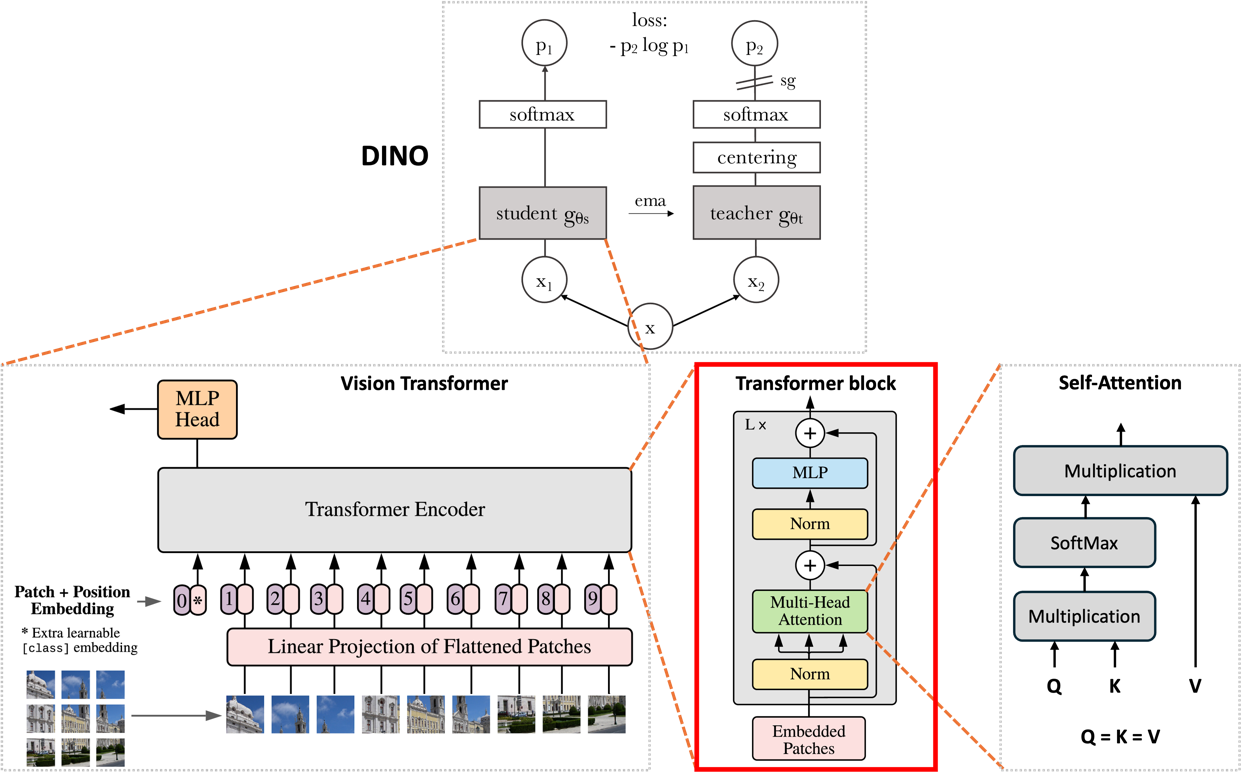

In [ ]:
display_thumbnail(img_fpath=base_dir+'thumbnails/overview_vitblock.png', downsample=3)

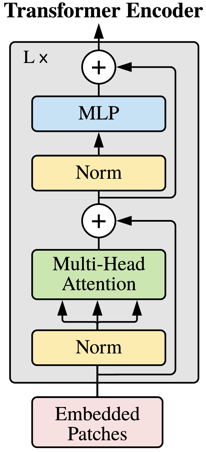

In [ ]:
display_thumbnail(img_fpath=base_dir+'thumbnails/vit_block.png', downsample=3)

In [ ]:
class VisionTransformerBlock(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_heads, is_verbose=False):
        '''
        :param input_dim: input dimension of each token
        :param hidden_dim: hidden dimension of each token
        :param num_heads: number of attention heads
        :param is_verbose: flag indicating whether to print
        '''
        super().__init__()
        self.is_verbose = is_verbose

        self.norm1 = nn.LayerNorm(input_dim)
        self.attention = MultiHeadSelfAttention(
            input_dim=input_dim,
            hidden_dim=hidden_dim,
            num_heads=num_heads,
            is_verbose=False
        )
        self.norm2 = nn.LayerNorm(input_dim)
        self.mlp = MLP(
            input_dim=input_dim,
            hidden_dim=hidden_dim,
            output_dim=input_dim,
            is_verbose=False
        )

    def forward(self, input: torch.Tensor):
        '''
        :param input: input tensor of shape (batch_size, num_tokens, input_dim)
        :return: output tensor of shape (batch_size, num_tokens, input_dim)
        '''
        norm1_output = self.norm1(input)
        if self.is_verbose:
            print('Norm1 output: ', norm1_output.shape)

        # multi-head self-attention
        attention_output = self.attention(norm1_output)
        if self.is_verbose:
            print('Multi-head Self-attention output: ', attention_output.shape)

        interim = input + attention_output
        if self.is_verbose:
            print('Intermediate output: ', interim.shape, '\n')

        norm2_output = self.norm2(interim)
        if self.is_verbose:
            print('Norm2 output: ', norm2_output.shape)

        mlp_output = self.mlp(norm2_output)
        if self.is_verbose:
            print('MLP output: ', mlp_output.shape)

        output = interim + mlp_output
        if self.is_verbose:
            print('Final output: ', output.shape)

        return output

In [ ]:
# Example usage:

# define input: (batch_size, num_tokens, dim)
batch_size, num_tokens, input_dim = 1, 10, 128
x = torch.randn(batch_size, num_tokens, input_dim)
print('Input: ', input.shape, '\n')

# instantiate transformer block
hidden_dim, num_heads = 64, 8
model = VisionTransformerBlock(
    input_dim=input_dim,
    hidden_dim=hidden_dim,
    num_heads=num_heads,
    is_verbose=True
)

# forward pass
output = model(x)

# sanity check
assert output.shape == (batch_size, num_tokens, input_dim)
print('Successful: Output shape is correct!')

Input:  torch.Size([1, 10, 128]) 

Norm1 output:  torch.Size([1, 10, 128])
Multi-head Self-attention output:  torch.Size([1, 10, 128])
Intermediate output:  torch.Size([1, 10, 128]) 

Norm2 output:  torch.Size([1, 10, 128])
MLP output:  torch.Size([1, 10, 128])
Final output:  torch.Size([1, 10, 128])
Successful: Output shape is correct!


### ViT

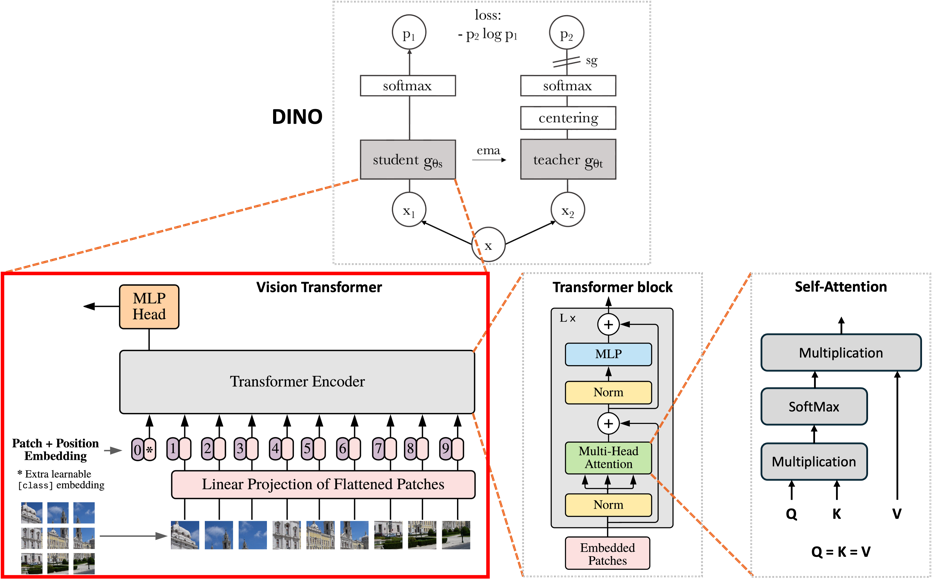

In [ ]:
display_thumbnail(img_fpath=base_dir+'thumbnails/overview_vit.png', downsample=4)

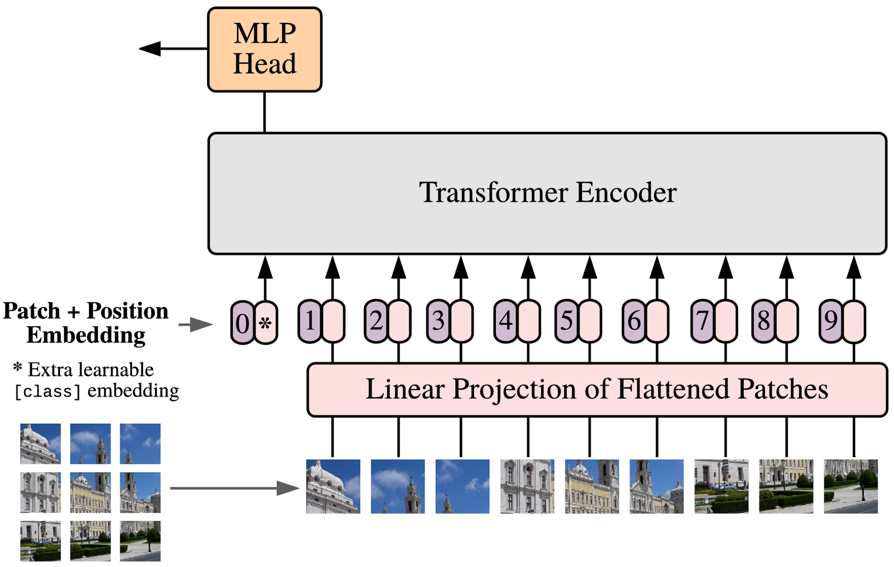

In [ ]:
display_thumbnail(img_fpath=base_dir+'thumbnails/vit.png', downsample=4)

In [ ]:
class VisionTransformer(nn.Module):
    def __init__(
        self,
        img_size: int,
        in_channels: int,
        patch_size: int,
        patch_embed_dim: int,
        num_heads: int,
        hidden_dim: int,
        num_vit_blocks: int,
        is_verbose: bool=False,
        **kwargs
    ):
        '''
        :param img_size: input image size
        :param in_channels: number of channels in input image
        :param patch_size: size of each patch token
        :param patch_embed_dim: embedding dimension for each patch token
        :param num_heads: number of heads in Multi-head Self-attention
        :param hidden_dim: hidden dimension in Multi-head Self-attention
        :param num_vit_blocks: number of ViT blocks
        :param is_verbose: flag indicating whether to print
        :param kwargs:
        '''
        super(VisionTransformer, self).__init__()

        self.patch_size = patch_size
        self.is_verbose = is_verbose

        # calculate number of patches in input image
        self.num_patches = (img_size // patch_size) ** 2
        if self.is_verbose:
            print('number of patch tokens: ', self.num_patches)

        # projection layer to convert input image into patches and extract patch linear embedding
        self.projection = nn.Conv2d(in_channels, patch_embed_dim, kernel_size=patch_size, stride=patch_size)

        # initialize [CLS] token
        self.cls_token = nn.Parameter(torch.zeros(1, 1, patch_embed_dim))

        # initialize position encoding
        self.position_embeddings = nn.Parameter(torch.zeros(1, self.num_patches + 1, patch_embed_dim))

        self.transformer_blocks = nn.ModuleList([
            VisionTransformerBlock(
                input_dim=patch_embed_dim,
                hidden_dim=hidden_dim,
                num_heads=num_heads,
                is_verbose=False
            )
            for _ in range(num_vit_blocks)
        ])
        self.norm = nn.LayerNorm(patch_embed_dim)

    def forward(self, input):
        '''
        :param input: input tensor of shape (batch_size, in_channels, img_size, img_size)
        :return: output tensor of shape (batch_size, patch_embed_dim)
        '''

        # 1. convert image into patch tokens and extract patch linear embedding
        patch_tokens = self._image_to_tokens(input)                      # (batch_size, num_patches, patch_embed_dim)
        if self.is_verbose:
            print('patch tokens shape: ', patch_tokens.shape)

        # 2. concatenate the [CLS] token to the patch tokens
        tokens = self._concatenate_cls_token(patch_tokens=patch_tokens)  # (batch_size, num_patches + 1, patch_embed_dim)
        if self.is_verbose:
            print('patch tokens + cls token shape: ', tokens.shape)

        # 3. add positional encoding to each token
        tokens = tokens + self.position_embeddings                       # (batch_size, num_patches + 1, patch_embed_dim)
        if self.is_verbose:
            print('patch tokens + cls token with position embeddings shape: ', tokens.shape)

        # 4. pass through multiple ViT blocks
        for i, block in enumerate(self.transformer_blocks):
            tokens = block(tokens)
            if self.is_verbose:
                print(f'transformer block {i} output shape: ', tokens.shape)

        # 5. layer normalization
        norm_tokens = self.norm(tokens)

        # 6. return output [CLS] token
        cls_token_final = norm_tokens[:, 0]
        if self.is_verbose:
            print('output cls token shape: ', cls_token_final.shape)

        return cls_token_final

    def _image_to_tokens(self, input):
        patches = self.projection(input)                        # (batch_size, patch_embed_dim, num_patches^(1/2), num_patches^(1/2))
        patches = patches.flatten(2)                            # (batch_size, patch_embed_dim, num_patches)
        return patches.transpose(1, 2)                          # (batch_size, num_patches, patch_embed_dim)

    def _concatenate_cls_token(self, patch_tokens):
        batch_size = patch_tokens.shape[0]
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)         # (batch_size, 1, patch_embed_dim)
        return torch.cat((cls_tokens, patch_tokens), dim=1)            # (batch_size, num_patches + 1, patch_embed_dim)

In [ ]:
# Example usage:

# define input: (batch_size, in_channels, img_size, img_size)
batch_size = 1
img_size, in_channels = 224, 3
input = torch.randn(batch_size, in_channels, img_size, img_size)
print('Input: ', input.shape, '\n')

# instantiate ViT
patch_size = 16
patch_embed_dim = 128
num_heads, hidden_dim = 8, 64
num_vit_blocks = 2

model = VisionTransformer(
    img_size=img_size,
    in_channels=in_channels,
    patch_size=patch_size,
    patch_embed_dim=patch_embed_dim,
    num_heads=num_heads,
    hidden_dim=hidden_dim,
    num_vit_blocks=num_vit_blocks,
    is_verbose=True
)

# forward pass
output = model(input)

# sanity check
assert output.shape == (batch_size, patch_embed_dim)
print('Successful: Output shape is correct!')

Input:  torch.Size([1, 3, 224, 224]) 

number of patch tokens:  196
patch tokens shape:  torch.Size([1, 196, 128])
patch tokens + cls token shape:  torch.Size([1, 197, 128])
patch tokens + cls token with position embeddings shape:  torch.Size([1, 197, 128])
transformer block 0 output shape:  torch.Size([1, 197, 128])
transformer block 1 output shape:  torch.Size([1, 197, 128])
output cls token shape:  torch.Size([1, 128])
Successful: Output shape is correct!


# DINO

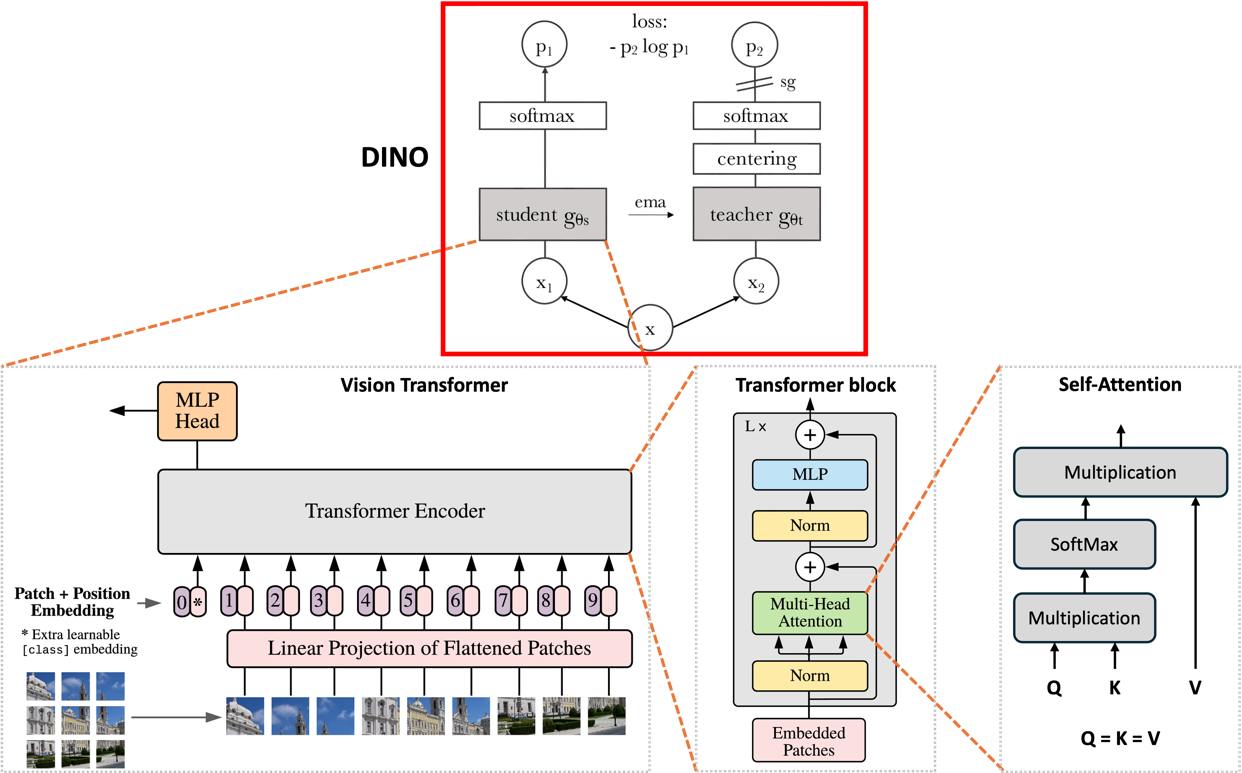

In [ ]:
display_thumbnail(img_fpath=base_dir+'thumbnails/overview_dino.png', downsample=3)

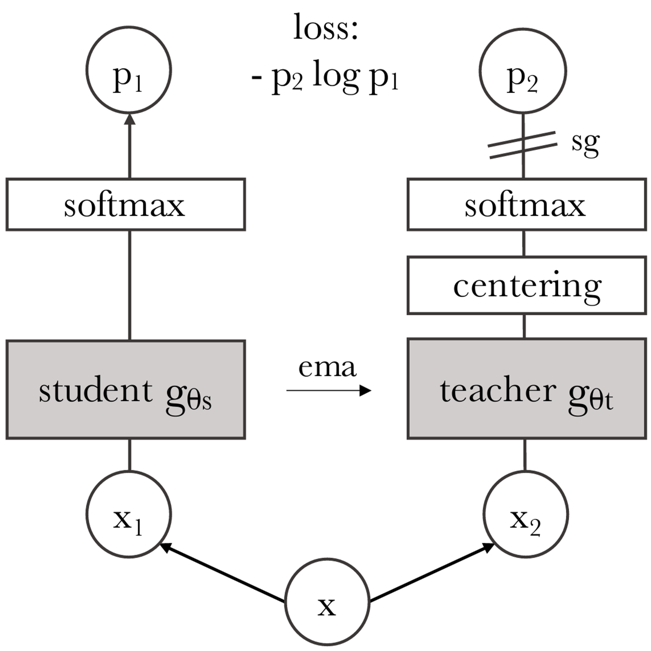

In [ ]:
display_thumbnail(img_fpath=base_dir+'thumbnails/dino.png', downsample=3)

In [ ]:
import dino_model
importlib.reload(dino_model)
from dino_model import VisionTransformer, get_student_model, get_teacher_model

from dino_loss import DINOLoss

import dino_dataloader
importlib.reload(dino_dataloader)
from dino_dataloader import DINODataSet

import dino_utils
importlib.reload(dino_utils)
from dino_utils import dict_to_namespace, get_params_groups, cosine_scheduler, visualize_crops, visualize_dino_loss

In [ ]:
args = {
    'seed': 0,
    'checkpoint_dir': dino_checkpoint_dir,
    'model_params': {
        'vit': {
            'img_size': 224,
            'in_channels': 3,
            'patch_size': 16,
            'patch_embed_dim': 128,
            'num_heads': 8,
            'hidden_dim': 64,
            'num_vit_blocks': 2,
        },
        'dinohead': {
            'out_dim': 1024
        }
    },
    'data_params': {
        'global_crops_size': 224,
        'global_crops_scale': (0.4, 1.),
        'global_crops_number': 2,
        'local_crops_size': 96,
        'local_crops_scale': (0.05, 0.4),
        'local_crops_number': 8
    },
    'train_params': {
        'epochs': 5,
        'batch_size': 1,
        'num_workers': 0,
        'freeze_last_layer': 1,
        'loss': {
            'warmup_teacher_temp': 0.04,
            'warmup_teacher_temp_epochs': 2,
            'teacher_temp': 0.04,
            'student_temp': 0.1
        },
        'optim': {
            'lr': 0.0005,
            'min_lr': 1.0e-6,
            'optimizer': 'adamw'
        },
        'scheduler': {
            'warmup_epochs': 2,
            'weight_decay': 0.04,
            'weight_decay_end': 0.4,
            'momentum_teacher': 0.996
        },
    }
}
args = dict_to_namespace(args)

### DINO Dataloader

In [ ]:
dataset = DINODataSet(
    global_crops_size=args.data_params.global_crops_size,
    global_crops_scale=args.data_params.global_crops_scale,
    local_crops_size=args.data_params.local_crops_size,
    local_crops_scale=args.data_params.local_crops_scale,
    local_crops_number=args.data_params.local_crops_number,
    fpath=train_data_fpath
)
data_loader = DataLoader(
    dataset,
    batch_size=args.train_params.batch_size,
    num_workers=args.train_params.num_workers,
    shuffle=True,
    drop_last=True
)

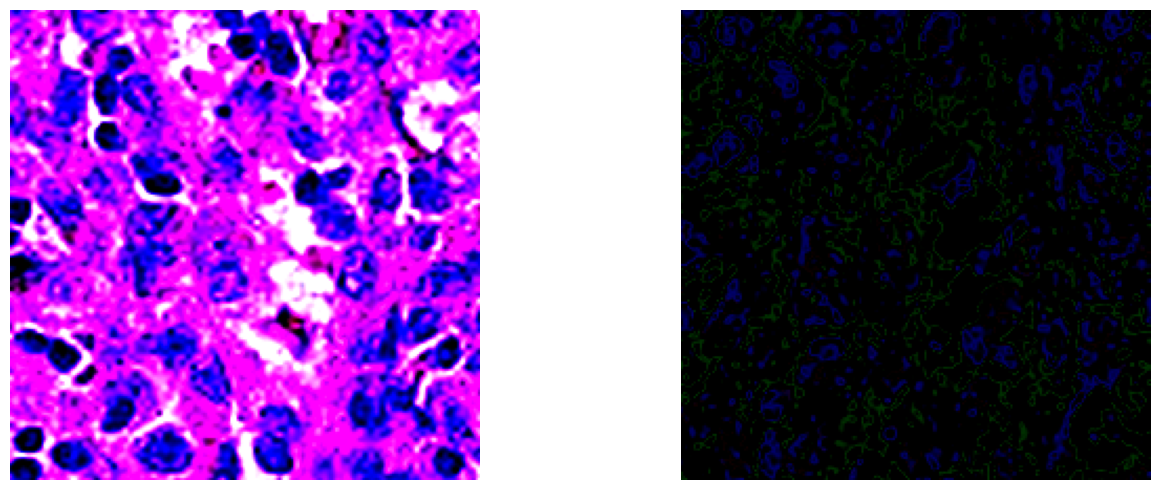

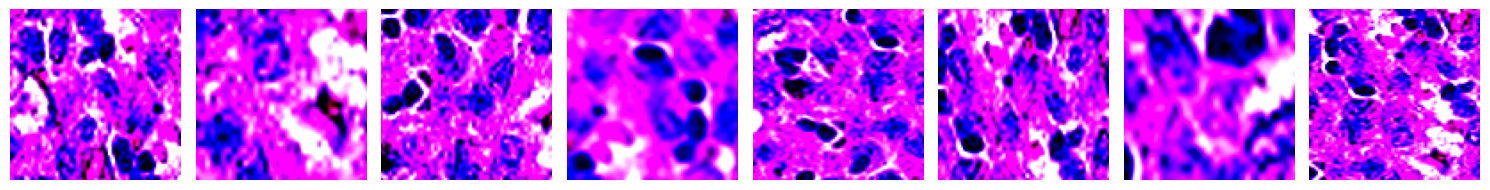

In [ ]:
for crops, _ in data_loader:
    global_crops = crops[:2]
    local_crops = crops[2:]
    visualize_crops(crops=global_crops)
    visualize_crops(crops=local_crops)
    break

### DINO Models

In [ ]:
# define student and teacher DINO models
student = get_student_model(args)
teacher = get_teacher_model(args)

# teacher and student start with the same weights
teacher.load_state_dict(student.state_dict())

# there is no backpropagation through the teacher, so no need for gradients
for p in teacher.parameters():
    p.requires_grad = False

### DINO Training

In [ ]:
class DINOTrainer:
    def __init__(self, args, data_fpath: str):
        self.args = args
        self.data_fpath = data_fpath

        # directory path to save outputs
        self.checkpoint_dir = args.checkpoint_dir
        os.makedirs(self.checkpoint_dir, exist_ok=True)

        # device
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def process(self):
        # define dataloader
        self.data_loader = self._get_dataloader()

        # define models
        self.student, self.teacher = self._get_models()

        # define loss function
        self.dino_loss = self._get_loss_criterion()

        # define optimizer
        self.optimizer = self._get_optimizer(network=self.student)

        # define schedulers
        self.lr_schedule, self.wd_schedule, self.momentum_schedule = self._get_scheduler(
            data_loader=self.data_loader
        )

        # ============ start training ============
        print('DINO training started ...')
        for epoch in tqdm(range(self.args.train_params.epochs)):
            # training one DINO epoch
            train_stats = self._train_one_epoch(epoch)

            # save model checkpoint
            self._save_checkpoint(epoch=epoch, train_stats=train_stats)

        print('DINO training completed :)')

    def _train_one_epoch(self, epoch):
        losses = []

        for it, (images, _) in enumerate(self.data_loader):
            # update weight decay and learning rate according to their schedule
            self._update_params(epoch=epoch, iteration=it)

            # move images to gpu
            images = [im.to(self.device) for im in images]

            # teacher and student forward passes
            teacher_output = self.teacher(images[:2])  # only the 2 global views pass through the teacher
            student_output = self.student(images)

            # compute dino loss
            loss = self.dino_loss(student_output, teacher_output, epoch)

            # student update
            self.optimizer.zero_grad()
            loss.backward()

            # update student
            self.optimizer.step()

            # update teacher (EMA)
            self._update_teacher(iteration=it)

            # logging
            losses.append(loss.item())

        return {'loss': sum(losses) / len(losses)}

    def _get_dataloader(self):
        dataset = DINODataSet(
            global_crops_size=self.args.data_params.global_crops_size,
            global_crops_scale=self.args.data_params.global_crops_scale,
            local_crops_size=self.args.data_params.local_crops_size,
            local_crops_scale=self.args.data_params.local_crops_scale,
            local_crops_number=self.args.data_params.local_crops_number,
            fpath=self.data_fpath
        )
        data_loader = DataLoader(
            dataset,
            batch_size=self.args.train_params.batch_size,
            num_workers=self.args.train_params.num_workers,
            shuffle=True,
            drop_last=True
        )
        return data_loader

    def _get_models(self):
        # define student and teacher DINO models
        student = get_student_model(self.args)
        teacher = get_teacher_model(self.args)

        # teacher and student start with the same weights
        teacher.load_state_dict(student.state_dict())

        # there is no backpropagation through the teacher, so no need for gradients
        for p in teacher.parameters():
            p.requires_grad = False

        # move networks to device
        student, teacher = student.to(self.device), teacher.to(self.device)

        return student, teacher

    def _get_loss_criterion(self):
        return DINOLoss(
            out_dim=self.args.model_params.dinohead.out_dim,
            ncrops=self.args.data_params.global_crops_number + self.args.data_params.local_crops_number,
            warmup_teacher_temp=self.args.train_params.loss.warmup_teacher_temp,
            teacher_temp=self.args.train_params.loss.teacher_temp,
            warmup_teacher_temp_epochs=self.args.train_params.loss.warmup_teacher_temp_epochs,
            nepochs=self.args.train_params.epochs,
            student_temp=self.args.train_params.loss.student_temp
        ).to(self.device)

    def _get_optimizer(self, network: nn.Module):
        params_groups = get_params_groups(network)
        return torch.optim.AdamW(params_groups)

    def _get_scheduler(self, data_loader: DataLoader):
        lr_schedule = cosine_scheduler(
            self.args.train_params.optim.lr * self.args.train_params.batch_size / 256.0,  # linear scaling rule
            self.args.train_params.optim.min_lr,
            self.args.train_params.epochs,
            len(data_loader),
            warmup_epochs=self.args.train_params.scheduler.warmup_epochs
        )
        wd_schedule = cosine_scheduler(
            self.args.train_params.scheduler.weight_decay,
            self.args.train_params.scheduler.weight_decay_end,
            self.args.train_params.epochs,
            len(data_loader)
        )
        # momentum parameter is increased to 1. during training with a cosine schedule
        momentum_schedule = cosine_scheduler(
            self.args.train_params.scheduler.momentum_teacher,
            1,
            self.args.train_params.epochs,
            len(data_loader)
        )

        return lr_schedule, wd_schedule, momentum_schedule

    def _save_checkpoint(self, epoch, train_stats):
        # save model checkpoint
        save_dict = {
            'student': self.student.state_dict(),
            'teacher': self.teacher.state_dict(),
            'optimizer': self.optimizer.state_dict(),
            'epoch': epoch + 1,
            'args': self.args,
            'dino_loss': self.dino_loss.state_dict(),
            'train_loss': train_stats['loss']
        }
        torch.save(save_dict, os.path.join(self.checkpoint_dir, 'checkpoint.pth'))

        # write logs
        log_stats = {
            'epoch': epoch,
            **{f"train_{k}": v for k, v in train_stats.items()},
        }
        with open(os.path.join(self.checkpoint_dir, 'log.txt'), 'a') as f:
            f.write(json.dumps(log_stats) + "\n")

    def _update_params(self, epoch, iteration):
        # update weight decay and learning rate according to their schedule
        it = len(self.data_loader) * epoch + iteration                  # global training iteration

        for i, param_group in enumerate(self.optimizer.param_groups):
            param_group["lr"] = self.lr_schedule[it]
            if i == 0:                                                  # only the first group is regularized
                param_group["weight_decay"] = self.wd_schedule[it]

    def _update_teacher(self, iteration):
        with torch.no_grad():
            m = self.momentum_schedule[iteration]         # momentum parameter
            for param_q, param_k in zip(self.student.parameters(), self.teacher.parameters()):
                param_k.data.mul_(m).add_((1 - m) * param_q.detach().data)


In [ ]:
dino_trainer = DINOTrainer(
    args=args,
    data_fpath=train_data_fpath
)

# start training
dino_trainer.process()

DINO training started ...


100%|██████████| 5/5 [04:58<00:00, 59.69s/it]

DINO training completed :)


### Plot DINO Loss

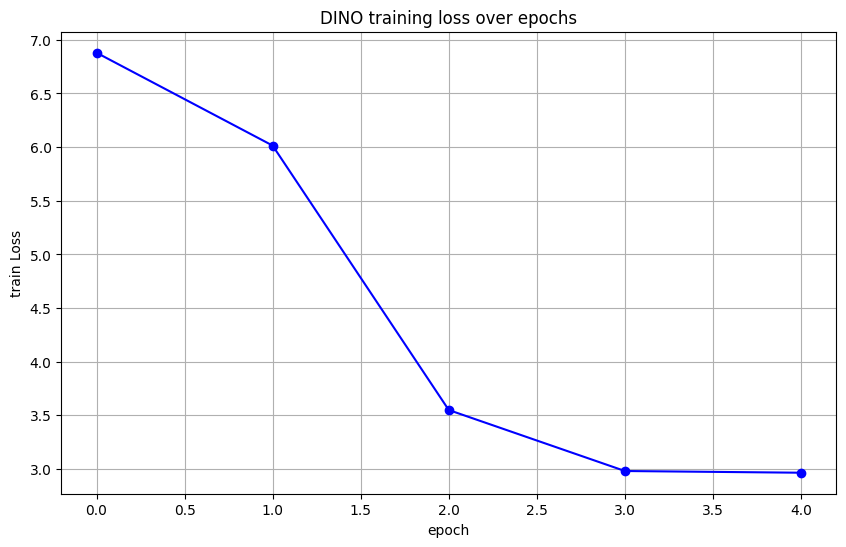

In [ ]:
epochs = []
train_losses = []

# read the DINO log
with open(os.path.join(args.checkpoint_dir, 'log.txt'), 'r') as file:
    for line in file:
        data = json.loads(line)
        epochs.append(data['epoch'])
        train_losses.append(data['train_loss'])

# plot the losse
visualize_dino_loss(
    epochs=epochs,
    losses=train_losses
)

# Downstream applications

## Load pretrained ViT model with DINO

In [ ]:
# downloaded from Hugging Face [https://huggingface.co/timm/vit_small_patch16_224.dino]
pretrained_model = torch.jit.load(os.path.join(pretrained_checkpoint_dir, 'vit_small_patch16_224_dino.pt'))
pretrained_model.eval()

RecursiveScriptModule(
  original_name=VisionTransformer
  (patch_embed): RecursiveScriptModule(
    original_name=PatchEmbed
    (proj): RecursiveScriptModule(original_name=Conv2d)
    (norm): RecursiveScriptModule(original_name=Identity)
  )
  (pos_drop): RecursiveScriptModule(original_name=Dropout)
  (patch_drop): RecursiveScriptModule(original_name=Identity)
  (norm_pre): RecursiveScriptModule(original_name=Identity)
  (blocks): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(
      original_name=Block
      (norm1): RecursiveScriptModule(original_name=LayerNorm)
      (attn): RecursiveScriptModule(
        original_name=Attention
        (qkv): RecursiveScriptModule(original_name=Linear)
        (q_norm): RecursiveScriptModule(original_name=Identity)
        (k_norm): RecursiveScriptModule(original_name=Identity)
        (attn_drop): RecursiveScriptModule(original_name=Dropout)
        (proj): RecursiveScriptModule(original_name=Linear)
        (

## Featurize train, val, test images

In [ ]:
import downstream_utils
importlib.reload(downstream_utils)
from downstream_utils import *

ModuleNotFoundError: No module named 'downstream_utils'

In [ ]:
# define image preprocessor
preprocess_image = PreprocessImage()

def featurize_images(fpath: str):
    # read image data
    data = read_dataset(fpath)

    # featurize
    features = []
    for idx in tqdm(range(data.shape[0])):
        # get image
        image = data[idx]

        # preprocess images
        image = preprocess_image.process(image=image)

        # featurize
        feature = pretrained_model(image)
        features.append(feature.detach().cpu().numpy())

    # compile features
    return np.vstack(features)

In [ ]:
# featurize images
train_features = featurize_images(fpath=train_data_fpath)
print('train features: ', train_features.shape)

val_features = featurize_images(fpath=val_data_fpath)
print('val features: ', val_features.shape)

test_features = featurize_images(fpath=test_data_fpath)
print('test features: ', test_features.shape)


100%|██████████| 500/500 [00:15<00:00, 33.03it/s]


train features:  (500, 384)


100%|██████████| 500/500 [00:14<00:00, 34.05it/s]


val features:  (500, 384)


100%|██████████| 500/500 [00:14<00:00, 34.28it/s]

test features:  (500, 384)


## Read train, val, test labels

In [ ]:
train_labels = read_dataset(file_path=train_labels_fpath)
train_labels = train_labels.squeeze().astype(np.float32)
print('train labels: ', train_labels.shape)

val_labels = read_dataset(file_path=val_labels_fpath)
val_labels = val_labels.squeeze().astype(np.float32)
print('val labels: ', val_labels.shape)

test_labels = read_dataset(file_path=test_labels_fpath)
test_labels = test_labels.squeeze().astype(np.float32)
print('test labels: ', test_labels.shape)

train labels:  (500,)
val labels:  (500,)
test labels:  (500,)


## t-SNE visualization of image features


Train features tsne: (500, 2)


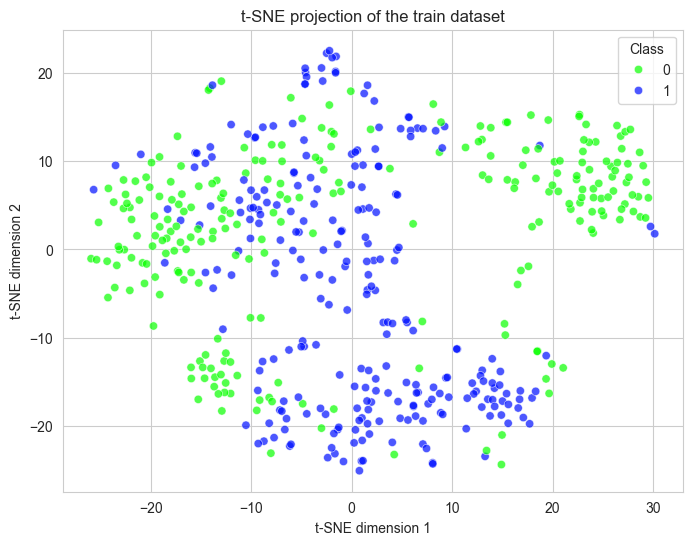

In [ ]:
# apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
train_features_tsne = tsne.fit_transform(train_features)
print('Train features tsne:', train_features_tsne.shape)

# plot the t-SNE map. color the points as per class labels
plot_tsne(
    features_tsne=train_features_tsne,
    labels=train_labels,
    title='t-SNE projection of the train dataset'
)

## Downstream image classification (training, validation and testing)

## Parameters to play

In [ ]:
num_epochs = 50
batch_size = 16
learning_rate = 0.0001
input_dim = train_features.shape[1]

## Prepare data and labels

In [ ]:
# Convert numpy arrays to PyTorch tensors
train_features_tensor = torch.tensor(train_features)
val_features_tensor = torch.tensor(val_features)
test_features_tensor = torch.tensor(test_features)

train_labels_tensor = torch.tensor(train_labels).unsqueeze(1)
val_labels_tensor = torch.tensor(val_labels).unsqueeze(1)
test_labels_tensor = torch.tensor(test_labels).unsqueeze(1)

In [ ]:
# Create Dataset and DataLoader for each dataset
train_dataset = TensorDataset(train_features_tensor, train_labels_tensor)
val_dataset = TensorDataset(val_features_tensor, val_labels_tensor)
test_dataset = TensorDataset(test_features_tensor, test_labels_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Define Classifier

In [ ]:
# Define a simple MLP model
class MLPClassifier(nn.Module):
    def __init__(self, input_dim):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 16)
        self.fc2 = nn.Linear(16, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

In [ ]:
# Initialize the model
classifier = MLPClassifier(
    input_dim=input_dim
)

# Initialize the loss function
criterion = nn.BCELoss()  # Binary Cross Entropy Loss

# Initialize the optimizer
optimizer = torch.optim.Adam(classifier.parameters(), lr=learning_rate)

## Train + Validatin Loop

In [ ]:
# Classifier development loop (Training + Validation)
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    # Set the classifier to training mode
    classifier.train()

    # Initialize the training loss
    train_loss = 0.0
    train_total = 0
    train_correct = 0

    # Training loop
    for data_batch, labels_batch in train_loader:
        # Zero the gradients of the optimizer
        optimizer.zero_grad()

        # Forward pass: Compute predicted outputs by passing train_features to the classifier
        outputs = classifier(data_batch).squeeze()

        # Calculate the loss
        loss = criterion(outputs, labels_batch.squeeze())

        # Backward pass: Compute gradient of the loss with respect to classifier parameters
        loss.backward()

        # Perform a single optimization step (parameter update)
        optimizer.step()

        # Accumulate the training loss
        train_loss += loss.item()

        # Convert outputs to binary predictions (0 or 1) based on a threshold of 0.5
        predicted = (outputs > 0.5).float()

        # Accumulate the total number of samples
        train_total += labels_batch.size(0)

        # Accumulate the number of correct predictions
        train_correct += (predicted == labels_batch.squeeze()).sum().item()

    # Compute the average training loss
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    train_accuracies.append(train_correct / train_total)

    # Validation loop
    # Set the classifier to evaluation mode
    classifier.eval()

    # Initialize the validation loss
    val_loss = 0.0
    val_total = 0
    val_correct = 0

     # Disable gradient computation for validation
    with torch.no_grad():
        for data_batch, labels_batch in val_loader:
            # Forward pass: Compute predicted outputs
            outputs = classifier(data_batch).squeeze()

            # Calculate the validation loss
            loss = criterion(outputs, labels_batch.squeeze())

            # Accumulate the validation loss
            val_loss += loss.item()

            # Convert outputs to binary predictions (0 or 1) based on a threshold of 0.5
            predicted = (outputs > 0.5).float()

            # Accumulate the total number of samples
            val_total += labels_batch.size(0)

            # Accumulate the number of correct predictions
            val_correct += (predicted == labels_batch.squeeze()).sum().item()

    # Compute the average validation loss
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_accuracies.append(val_correct/val_total)

    # Print the epoch number, training loss, and validation loss
    print(
        f'Epoch {epoch+1}/{num_epochs}, '
        f'Training Loss: {train_loss:.4f}, '
        f'Validation Loss: {val_loss:.4f}'
    )

Epoch 1/50, Training Loss: 0.6852, Validation Loss: 0.5968
Epoch 2/50, Training Loss: 0.5554, Validation Loss: 0.4993
Epoch 3/50, Training Loss: 0.4799, Validation Loss: 0.4477
Epoch 4/50, Training Loss: 0.4390, Validation Loss: 0.4174
Epoch 5/50, Training Loss: 0.4085, Validation Loss: 0.3944
Epoch 6/50, Training Loss: 0.3840, Validation Loss: 0.3803
Epoch 7/50, Training Loss: 0.3685, Validation Loss: 0.3716
Epoch 8/50, Training Loss: 0.3591, Validation Loss: 0.3536
Epoch 9/50, Training Loss: 0.3387, Validation Loss: 0.3438
Epoch 10/50, Training Loss: 0.3252, Validation Loss: 0.3349
Epoch 11/50, Training Loss: 0.3282, Validation Loss: 0.3275
Epoch 12/50, Training Loss: 0.3029, Validation Loss: 0.3247
Epoch 13/50, Training Loss: 0.2958, Validation Loss: 0.3172
Epoch 14/50, Training Loss: 0.2892, Validation Loss: 0.3132
Epoch 15/50, Training Loss: 0.2789, Validation Loss: 0.3089
Epoch 16/50, Training Loss: 0.2685, Validation Loss: 0.3045
Epoch 17/50, Training Loss: 0.2680, Validation Lo

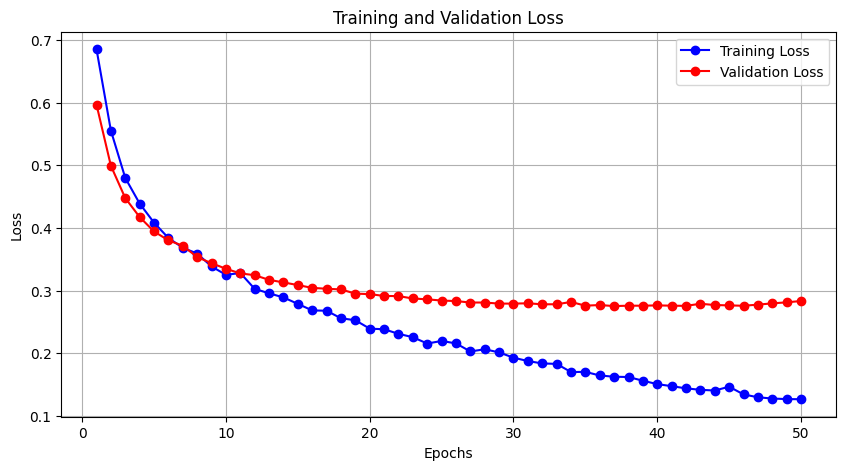

In [ ]:
plot_train_val_losses(
    train_losses=train_losses,
    val_losses=val_losses,
    num_epochs=num_epochs
)

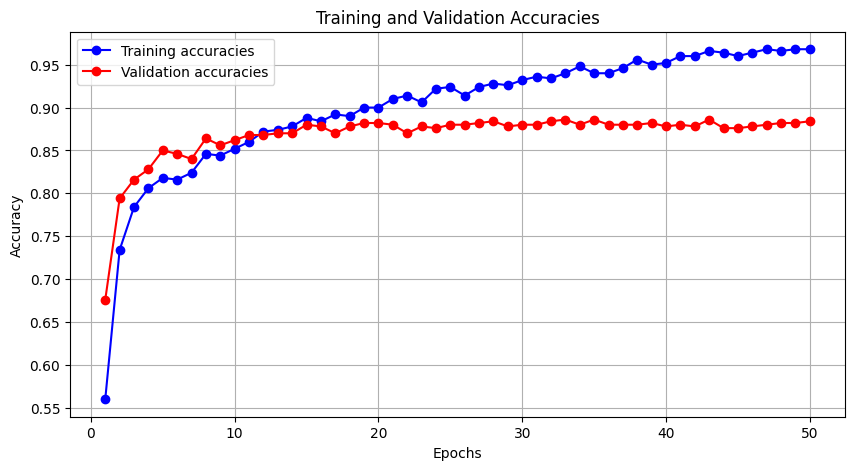

In [ ]:
plot_train_val_accuracies(
    train_accuracies=train_accuracies,
    val_accuracies=val_accuracies,
    num_epochs=num_epochs
)

## Testing

In [ ]:
# Testing loop

# Set the model to evaluation mode (disables dropout, batch normalization, etc.)
classifier.eval()

# Initialize the test loss to zero
test_loss = 0.0
 # Initialize the count of correct predictions to zero
correct = 0
# Initialize the total count of samples to zero
total = 0

# Disable gradient computation for testing (saves memory and computation)
with torch.no_grad():
    # Iterate over batches in the test DataLoader
    for data_batch, labels_batch in test_loader:
        # Forward pass: Compute predicted outputs by passing inputs to the classifier
        outputs = classifier(data_batch).squeeze()

        # Calculate the test loss
        loss = criterion(outputs, labels_batch.squeeze())

        # Accumulate the test loss
        test_loss += loss.item()

        # Convert outputs to binary predictions (0 or 1) based on a threshold of 0.5
        predicted = (outputs > 0.5).float()

        # Accumulate the total number of samples
        total += labels_batch.size(0)
        # Accumulate the number of correct predictions
        correct += (predicted == labels_batch.squeeze()).sum().item()

# Compute the average test loss
test_loss /= len(test_loader)
# Compute the test accuracy
accuracy = correct / total

# Print the test loss and accuracy
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.4f}')


Test Loss: 0.2862, Test Accuracy: 0.8900
